In [1]:
%pylab inline

/home/gjones/miniconda2/envs/readout/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
from kid_readout.interactive import *

INFO     2016-09-06 14:30:48,238 - kid_readout.<module>:13  kid_readout logging setup with default stream handler


In [3]:
from kid_readout.roach.tests.mock_valon import MockValon
from kid_readout.roach import tools
from kid_readout.roach import demodulator

In [4]:
ri = Roach2Heterodyne(roachip=ROACH2_IP, adc_valon=ROACH2_VALON, host_ip=ROACH2_HOST_IP,
                                  lo_valon=MockValon(), initialize=False)
ri.initialize(use_config=False)
ri.set_loopback(True)
ri.set_fft_gain(0)

INFO     2016-09-06 14:30:51,542 - kid_readout.roach.interface.initialize:464  Reinitializing system
INFO     2016-09-06 14:30:51,675 - kid_readout.roach.interface.initialize:471  Programming r2iq2xpfb14mcr18gb_2016_Jun_30_1104.bof
INFO     2016-09-06 14:30:52,273 - kid_readout.roach.interface.set_fft_gain:307  Set FFT gain integer to 4.
INFO     2016-09-06 14:30:54,288 - kid_readout.roach.interface.initialize:488  Requested sampling rate 512.0 MHz. Estimated sampling rate 513.0 MHz
INFO     2016-09-06 14:30:57,696 - kid_readout.roach.r2heterodyne.initialize:72  Succesfully recalibrated QDR
INFO     2016-09-06 14:30:57,778 - kid_readout.roach.interface.set_fft_gain:307  Set FFT gain integer to 0.


In [5]:
ri.set_fft_gain(4)

INFO     2016-09-06 14:30:59,969 - kid_readout.roach.interface.set_fft_gain:307  Set FFT gain integer to 4.


In [6]:
nchan = 512
nsamp = 2**18
phases = tools.preset_phases(nchan)
phases[1] = 0.0
freqs = np.linspace(12.123, 252.3123,num=nchan)
ri.set_tone_baseband_freqs(freqs,nsamp=nsamp, phases=phases)
ri.select_fft_bins(range(nchan))
ri.phase0=None
gold_data,_ = ri.get_data(ri.blocks_per_second,demod=True)
raw_data,raw_seqno = ri.get_data(ri.blocks_per_second,demod=False)
stream_demod = demodulator.get_stream_demodulator_from_roach_state(ri.state,ri.active_state_arrays)
demod_data = stream_demod.demodulate_stream(raw_data,raw_seqno-ri.phase0)

In [14]:
gold_data.shape

(31252, 256)

In [46]:
stream_demod.hardware_delay_samples

-16025.6

In [47]:
stream_demod.hardware_delay_samples = 0

In [7]:
dwave,period = stream_demod.create_demodulation_waveform(raw_data.shape,raw_seqno-ri.phase0)

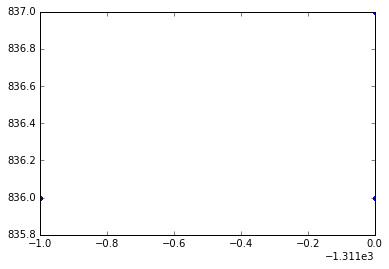

In [208]:
plot_ri(raw_data[:,1],'.')

In [8]:
err = np.abs(gold_data - demod_data).max(0)

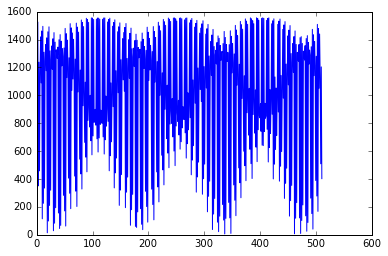

In [9]:
plot(np.abs(demod_data.real).max(0))

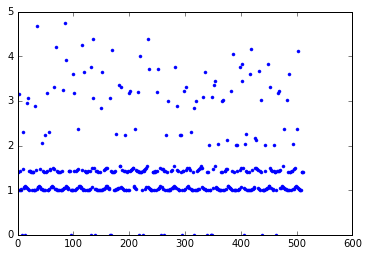

In [10]:
plot(err,'.')

In [165]:
err[:10]

array([ 1.00000991,  1.00107407,  1.00988204,  1.01801465,  1.04404304,
        1.06288534,  1.06285105,  1.47645409,  1.01809636,  1.42821368])

In [166]:
err.argmax()

152

In [144]:
err[235]

8.5119852354356091e-05

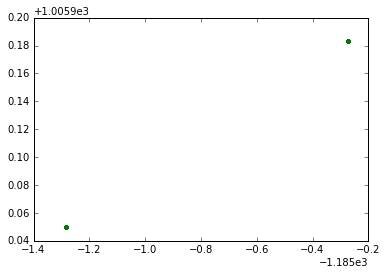

In [11]:
plot_ri(gold_data[:,153],'.')
plot_ri(demod_data[:,153],'.')

/home/gjones/miniconda2/envs/readout/lib/python2.7/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


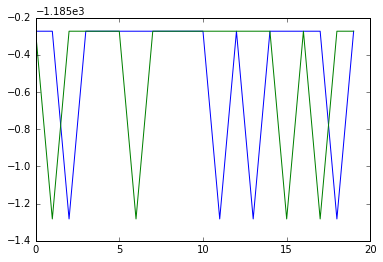

In [12]:
plot(gold_data[:20,153])
plot(demod_data[:20,153])


In [205]:
dwave.dtype

dtype('complex128')

In [95]:
raw_data.dtype

dtype('complex64')

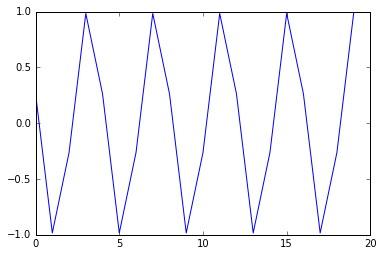

In [172]:
#plot(raw_data[:20,153].real)
plot(dwave.real[:20,3])

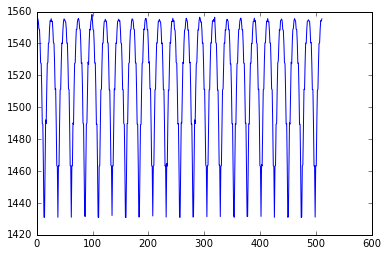

In [13]:
plot(np.abs(raw_data).max(0))

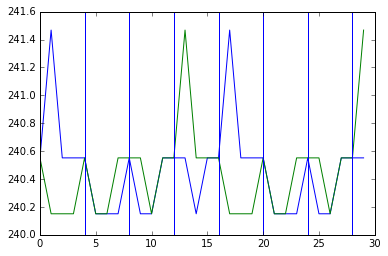

In [14]:
plot(dwave[:30,1]*raw_data[:30,1])
plot(gold_data[:30,1])
for k in range(8):
    axvline(k*4)

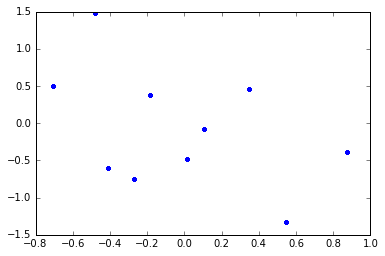

In [151]:
plot_ri(gold_data[1:,1]-demod_data[:-1,1],'.')
#plot_ri(demod_data[:,1],'.')

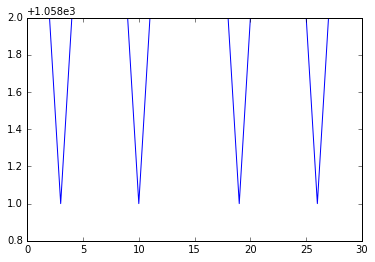

In [152]:
plot(raw_data[:30,0].imag)

In [39]:
from kid_readout.roach.calculate import packet_phase, tone_offset_frequency, get_offset_frequencies_period

In [242]:
from kid_readout.roach import calculate
reload(calculate)

<module 'kid_readout.roach.calculate' from '/home/gjones/kid_readout/kid_readout/roach/calculate.py'>

In [243]:
offset_freq = tone_offset_frequency(stream_demod.tone_bins,stream_demod.tone_nsamp,stream_demod.fft_bins,stream_demod.nfft)

In [244]:
pph = calculate.packet_phase((raw_seqno-ri.phase0)[0],offset_freq,512,16,2**14)

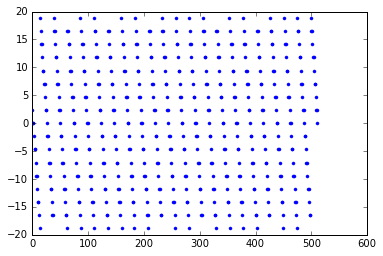

In [245]:
plot(pph,'.')

In [213]:
offset_freq[153]

0.25

In [214]:
get_offset_frequencies_period(offset_freq)

16

In [217]:
pphase = packet_phase((raw_seqno-ri.phase0)[0],offset_freq,stream_demod.num_channels,stream_demod.nfft,stream_demod.tone_nsamp)

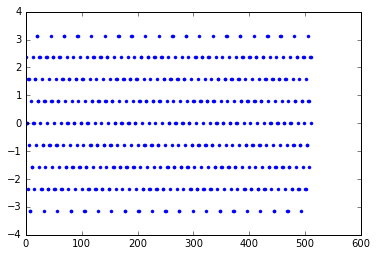

In [246]:
plot(np.angle(pphase),'.')

In [223]:
stream_demod.num_channels

512

In [227]:
2**18/(1024*2**13 / 512)

16

In [228]:
2**18/2**14

16

In [229]:
ri.blocks_per_second

15625.0

In [230]:
offset_freq[:10]

array([-0.0625,  0.    ,  0.    ,  0.0625,  0.125 ,  0.125 ,  0.1875,
        0.25  ,  0.25  ,  0.3125])

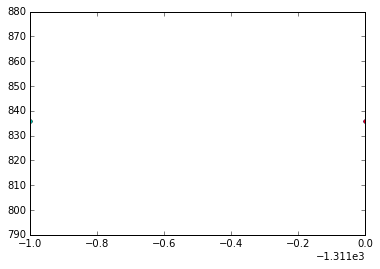

In [249]:
for k in range(32):
    d,sno = ri.get_data(2048,demod=False)
    #ppha = (packet_phase(sno[0]-ri.phase0,offset_freq,512,2**14,2**18)[0])
    ppha = np.exp(1j*calculate.packet_phase((sno[0]-ri.phase0),offset_freq,512,16,2**14))
    plot_ri(d[0,1]*ppha[1],'.')
#    plot_ri(ppha*1500,'x')

In [238]:
raw_seqno.dtype

dtype('uint32')

In [239]:
raw_seqno-ri.phase0

array([686735360, 686751744, 686768128, ..., 942686208, 942702592,
       942718976], dtype=uint32)

In [221]:
np.diff(raw_seqno[:10])

array([16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384, 16384], dtype=uint32)

In [240]:
1024//512

2

In [186]:
wc = stream_demod.compute_pfb_response(offset_freq)

In [197]:
512*stream_demod.tone_bins/float(stream_demod.tone_nsamp)

array([  12.3125    ,   12.78125   ,   13.25      ,   13.72070312,
         14.18945312,   14.65820312,   15.12890625,   15.59765625,
         16.06640625,   16.53515625,   17.00585938,   17.47460938,
         17.94335938,   18.4140625 ,   18.8828125 ,   19.3515625 ,
         19.8203125 ,   20.29101562,   20.75976562,   21.22851562,
         21.69726562,   22.16796875,   22.63671875,   23.10546875,
         23.57617188,   24.04492188,   24.51367188,   24.98242188,
         25.453125  ,   25.921875  ,   26.390625  ,   26.86132812,
         27.33007812,   27.79882812,   28.26757812,   28.73828125,
         29.20703125,   29.67578125,   30.14648438,   30.61523438,
         31.08398438,   31.55273438,   32.0234375 ,   32.4921875 ,
         32.9609375 ,   33.4296875 ,   33.90039062,   34.36914062,
         34.83789062,   35.30859375,   35.77734375,   36.24609375,
         36.71484375,   37.18554688,   37.65429688,   38.12304688,
         38.59375   ,   39.0625    ,   39.53125   ,   40.     

In [195]:
offset_freq*16

array([ 0.,  0.,  0.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,
        4.,  4.,  4.,  4.,  5.,  5.,  5.,  5.,  6.,  6.,  6.,  7.,  7.,
        7.,  7.,  8., -8.,  8., -7., -7., -7., -7., -6., -6., -6., -5.,
       -5., -5., -5., -4., -4., -4., -4., -3., -3., -3., -2., -2., -2.,
       -2., -1., -1., -1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  2.,  2.,
        2.,  2.,  3.,  3.,  3.,  3.,  4.,  4.,  4.,  5.,  5.,  5.,  5.,
        6.,  6.,  6.,  7.,  7.,  7.,  7.,  8., -8.,  8., -7., -7., -7.,
       -7., -6., -6., -6., -6., -5., -5., -5., -4., -4., -4., -4., -3.,
       -3., -3., -2., -2., -2., -2., -1., -1., -1.,  0.,  0.,  0.,  0.,
        1.,  1.,  1.,  1.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,  4.,  4.,
        4.,  5.,  5.,  5.,  5.,  6.,  6.,  6.,  7.,  7.,  7.,  7.,  8.,
       -8.,  8., -8., -7., -7., -7., -6., -6., -6., -6., -5., -5., -5.,
       -4., -4., -4., -4., -3., -3., -3., -2., -2., -2., -2., -1., -1.,
       -1., -1.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  2.,  2.,  2

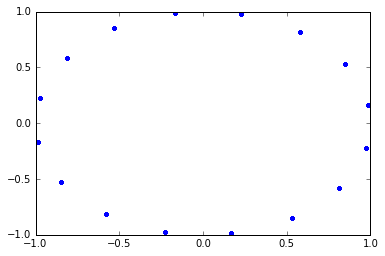

In [38]:
#plot_ri(raw_data[:,1],'.')
plot_ri(dwave[:,1],'.')

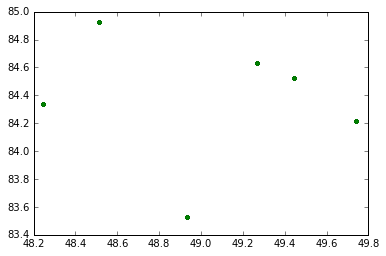

In [56]:
plot_ri(demod_data[:,58],'.')
plot_ri(gold_data[:,58],'.')

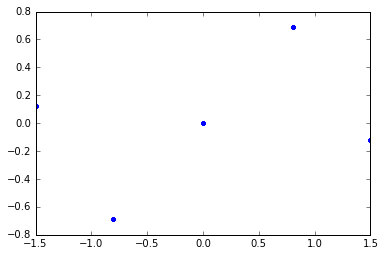

In [57]:
plot_ri(demod_data[:,58]-gold_data[:,58],'.')
